# Testing Grounds - Fit Loop
Creating a library that helps with the pytorch looping.

In [1522]:
import time
import math
import logging
import warnings

import numpy as np
import matplotlib.pyplot as plt

from uuid import uuid4
from pathlib import Path
from copy import deepcopy
from tqdm.autonotebook import tqdm
from typing import Union, List, Callable, Optional, Any, Dict, Tuple

from torch import Tensor
from torch.nn import Module
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

## LoopState

In [1347]:
class LoopState:
    """
    Maintains train/valid/test loop state for a single run of 
    a certain number of epochs, does not used to preserve state 
    between runs.
    """
    _stages = ['batch','epoch_start','epoch_end']
    _batch_step, _epoch_start, _epoch_end = _stages
    def __init__(self, phase:str, floop:FitLoop, no_cast:bool, 
                 no_float:bool, is_train:bool, is_test:bool,
                 dl:DataLoader
                ):
        """
        phase : phase name 'train', 'valid' or 'test'
        floop : the calling FitLoop object
        """
        self.__batch = ()
        self.__floop = floop
        self._no_cast = no_cast
        self._no_float = no_float
        self.phase = phase
        self.batch_num = 0
        self.epoch_num = 0
        self.metrics = {s:{} for s in self._stages}
        self.is_train = is_train
        self.is_test = is_test
        
        # For easy access
        bs = dl.batch_size
        dr = dl.drop_last
        sz = len(dl.dataset)
        bt = sz / bs
        
        # Gives dataset size and batch count
        self.size = sz
        self.batches = math.floor(bt) if dr else math.ceil(bt)
        self.batch_size = 0
    
    def __getattr__(self, name:str) -> Any:
        # To get attributes from the FitLoop object 
        # for use in the stage functions.
        return getattr(self.__floop, name)
    
    def __getitem__(self, metric_name:str):
        # To get the metrics stored in the batch step stage
        metric_value = self.metrics[self._batch_step][metric_name]
        try:
            return torch.tensor(metric_value).float()
        except:
            return metric_value
    
    """
    Getter and setter for the current batch
    """
    @property
    def batch(self) -> Tuple[Tensor,...]:
        if self._no_cast:
            return self.__batch
        
        return (
            d.to(device=self.device,dtype=self.dtype) 
            if d.is_floating_point() 
            else d.to(device=self.device,dtype=torch.long) 
            for d in self.__batch
        )
    
    @batch.setter
    def batch(self, current_batch:Tuple[Tensor,...]) -> None:
        self.__batch = current_batch
        
    """
    Functions to append rdict values to self.metrics
    """
    def _append(self, rdict:Dict[str, float], stage:str) -> None:
        #  Append metrics to the specific stage.
        if rdict is None:
            if stage == self._epoch_end:
                print(f"no rdict returned from: f{self.phase}_{stage}")
            """
            TODO: Add warning if rdict of stage is None
            """
            return
        
        for key in rdict:
            if key not in self.metrics[stage]:
                self.metrics[stage][key] = []
            self.metrics[stage][key].append(rdict[key])
            
    def _append_batch_step(self, rdict:Dict[str, float]) -> None:
        # Called after batch step rdict is returned
        self._append(rdict, self._batch_step)
        
    def _append_epoch_start(self, rdict:Dict[str, float]) -> None:
        # Called before epoch start
        self._append(rdict, self._epoch_start)
        
    def _append_epoch_end(self, rdict:Dict[str, float]) -> None:
        # Called after epoch end step rdict is returned
        self._append(rdict, self._epoch_end)
    
        
    """
    Functions to clear rdict values from self.metrics
    """
    def _clear(self, stage:str) -> None:
        # Clear the batch metrics at the end of the batch.
        for mlist in self.metrics[stage]:
            self.metrics[stage][mlist].clear()
            
    def _clear_batch_step(self) -> None:
        # Called before epoch start
        self._clear(self._batch_step)
        
    def _clear_epoch_start(self) -> None:
        # Called ??
        self._clear(self._epoch_start)
        
    def _clear_epoch_end(self) -> None:
        # Called after loop end
        self._clear(self._epoch_end)
    
    """
    State updates before epoch start and batch step stages
    """
    def _pre_epoch_start_update(self, epoch_num:int) -> None:
        self._clear_batch_step()
        self.batch_num = 0
        self.epoch_num = epoch_num
    
    def _pre_batch_step_update(self, current_batch):
        self.batch_size = current_batch[0].size(0)
        self.batch_num += 1
        self.batch = current_batch
    
    """
    Functions to get various metrics at different stages 
    """
    def _get_epoch_metric(self, criteria:str) -> float:
        # Last added metric that is to be used as a model 
        # selection criteria
        metric = self.metrics[self._epoch_end][criteria][-1]
        if self._no_float:
            return metric
        else:
            return float(metric)
    
    def _get_epoch_metrics(self, 
                display_metrics:Optional[Union[str,List[str]]]=None
                ) -> Dict[str,float]:
        # Return the last saved epoch metrics
        if isinstance(display_metrics, str):
            return {display_metricss:self._get_epoch_metric(display_metrics)}
        elif isinstance(display_metrics, list):
            return {
                metric:self._get_epoch_metric(metric)
                for metric in display_metrics
            }
        else:
            return {
                metric: self._get_epoch_metric(metric)
                for metric in self.metrics[self._epoch_end]
            }

## FitLoopDefaults

In [1481]:
class FitLoopDefaults:
    """
    Some default functions to be used with FitLoop,
    allows fit loop to work without having to define 
    anything.
    
    Doesn't use any lr_schedulers and just a single optimizer
    """
    batch_step_criteria = "running_correct"
    batch_step_loss = "running_loss"
    criteria = "accuracy"
    loss = "loss"
    
    """
    Section 1. BATCH STEP FUNCTIONS
    """
    @staticmethod
    def _common_batch_step(state: LoopState) -> Dict[str, float]:
        X, y = state.batch
        y_ = state.model(X)
        loss = state.loss_function(y_, y)

        return loss, {
            FitLoopDefaults.batch_step_criteria:
            (y_.argmax(dim=1) == y).sum().float().item(),
            FitLoopDefaults.batch_step_loss: (loss.item() * state.batch_size)
        }

    @staticmethod
    def train_step(state: LoopState) -> Dict[str, float]:
        loss, rdict = FitLoopDefaults._common_batch_step(state)
        loss.backward()
        optimizer.step()
        return rdict

    @staticmethod
    def valid_step(state: LoopState) -> Dict[str, float]:
        _, rdict = FitLoopDefaults._common_batch_step(state)
        return rdict

    @staticmethod
    def test_step(state: LoopState) -> Dict[str, float]:
        _, rdict = FitLoopDefaults._common_batch_step(state)
        return rdict

    
    """
    Section 2. EPOCH END STEPS FUNCTIONS
    """
    @staticmethod
    def _common_epoch_end(state: LoopState) -> Dict[str, float]:
        return {
            FitLoopDefaults.criteria: state[FitLoopDefaults.batch_step_criteria]\
                .sum().float().item() / state.size,
            FitLoopDefaults.loss:state[FitLoopDefaults.batch_step_loss]\
                .sum().float().item() / state.size
        }

    @staticmethod
    def train_epoch_end(state: LoopState) -> Dict[str, float]:
        return FitLoopDefaults._common_epoch_end(state)

    @staticmethod
    def valid_epoch_end(state: LoopState) -> Dict[str, float]:
        return FitLoopDefaults._common_epoch_end(state)

    @staticmethod
    def test_epoch_end(state: LoopState) -> Dict[str, float]:
        return FitLoopDefaults._common_epoch_end(state)

### Metric calls

```python
# Value access
Fitloop.metrics.train['loss']          # returns all losses from epoch end
Fitloop.metrics.train.end['loss']      # returns all losses from epoch end
Fitloop.metrics.train.start['loss']    # returns all losses from epoch start
Fitloop.metrics.train.batch['loss']    # returns all losses from batch step
 
Fitloop.metrics.train['loss'][0]       # returns losses for run 0 from epoch end
Fitloop.metrics.valid.batch['accu'][3] # returns all validation accuracies for batch step from run 3
 
# Value visualization 
Fitloop.metrics.plot()                 # plots validation criteria against training criteria (eg accuracy)
                                       # if criteria not available, then first key from rdict.
Fitloop.metrics.train.plot()           # if loss then loss else, plots first value from rdict
Fitloop.metrics.train.plot('loss')     # plots loss 
```

## Metrics/MetricsAggregator

In [1756]:
"""
run = 0
metric = 'loss'

FitLoop.metrics.valid.start[metric:dict][run:array] -> float
----
FitLoop.metrics.valid.start[metric][run]
MetricsAggregator.valid.start[metric][run]
Metrics.start[metric][run]

"""

class Metrics:
    """
    Class to keep track of metrics for a single phase.
    """
    def __init__(self, name, is_train, no_float):
        self.stages = []
        self._name = name
        self._runs = 0
        self._in_run = False
        self._is_train = is_train
        self._no_float = no_float
        
    def __repr__(self):
        stages = ', '.join(self.stages)
        return f"<Metrics({self._name}) :: stages:[{stages}] at {hex(id(self))}>"
    
    def _complete_run(self, is_train):
        """
        Set appropriate flags.
        Convert values for the run to numpy arrays.
        """
        if not is_train == self._is_train:
            return
        
        self._in_run = False
        for stage in self.stages:
            self_stage = getattr(self, stage)
            for metric in self_stage:
                m_run = self_stage[metric][self._runs - 1]
                try:
                    self_stage[metric][self._runs - 1] = np.array(m_run)
                except:
                    pass
                
    def _append(self, stage, rdict):
        """
        Add values in rdict to this object.
        Metrics.stage[name:str][run:int] -> value:float
        """
        if not self._in_run:
            # Set run flag and value
            self._in_run = True
            self._runs += 1
            
        if not hasattr(self, stage):
            self.stages.append(stage)
            setattr(self, stage, {})
            
        self_stage = getattr(self, stage)
        
        for key in rdict:
            val = rdict[key]
            if key not in self_stage:
                self_stage[key] = []
                
            if len(self_stage[key]) < self._runs:
                self_stage[key].append([])
                
            if not self._no_float:
                try:
                    val = float(val)
                except:
                    pass
            self_stage[key][self._runs - 1].append(val)
    
    def clear(self):
        """
        Clears all recorded metrics for this phase.
        """
        for stage in self.stages:
            getattr(self, stage).clear()
        self._runs = 0
        
    def __getitem__(self, item):
        stages = ['epoch_end','batch_step','epoch_start']
        for stage in stages:
            if stage not in self.stages:
                continue
            if item in getattr(self, stage):
                return getattr(self, stage)[item]
        else:
            raise KeyError(f"{item} not found")
            
    def _plot(self, name, metric, run_number, *args, **kwargs):
        if run_number is None:
            m = metric[-1]
        elif run_number is 'all':
            m = np.concatenate(metric)
        elif isinstance(run_number,int):
            m = metric[run_number]
        else:
            raise TypeError("invalid run_number")
        
        plt.plot(np.arange(len(m)),m,*args,**kwargs)
        plt.xlabel('iteration')
        plt.ylabel(name)
        plt.show()
        
    def plot(self, metric:str,run_number:Optional[Union[int,str]]=None, stage:Optional[str]=None,  
             *args, **kwargs) -> None:
        """
        Plots metric against iteration count for
        all phases ['train','valid'] available if the 
        iteration count matches, else it plots metric for 'train'
        
        To plot individual metrics use `FitLoop.M.phase.plot`
        To plot test metrics use `FitLoop.M.test.plot`
        
        phase = ['train','valid','test']
        check FitLoop.M.[phase].stages to check stages available.
        stages = ['epoch_end','batch_step','epoch_start']
        ----
        PARAMETERS:
         - metric : name of the metric that has to be plotted. eg: "running_loss"
         - run_number : metric of which run to be plotted.
             'all' -  metrics of all runs are plotted.
             n (int) - metrics of the nth run are plotted.
             None -  (default) the last run's metrics are plotted.
         - stage : metric from which stage to plot, 
             if None (default) metrics are checked in all stages in the 
             above order.
         - *args : agrs to pass to plt.plot
         - **kwargs : kwargs to pass to plt.plot
            
        """
        if stage is not None:
            if stage not in self.stages:
                raise ValueError(f'invalid stage: {stage}, choose from: {self.stages}')
            else:
                m = getattr(self, stage)[metric]
                self._plot(metric, m, run_number, *args,**kwargs)
        else:
            m = self[metric]
            self._plot(metric, m, run_number, *args, **kwargs)
    
class MetricsAggregator:
    """
    Class to keep track of metrics for all phases.
    """
    _sets = ['train','valid','test'] # DONT CHANGE THESE, A LOT MAY BREAK
    _TR, _VA, _TE = _sets
    def __init__(self):
        self.train_runs = 0
        self.test_runs = 0
        self._in_test = False
        self._in_train = False
        self._is_checkup = False
        self._no_float = None
        self.phases = []
    
    def __repr__(self):
        return f"<MetricsAggregator :: train_runs:{self.train_runs} test_runs:{self.test_runs} at {hex(id(self))}>"
    
    def _start_run(self, is_checkup:bool, is_test:bool, no_float:bool) -> None:
        """
        Set flags and run counters.
        """
        if is_checkup:
            self._is_checkup = True
            return
        
        self._no_float = no_float
        if is_test:
            self._in_test = True
            self.test_runs += 1
        else:
            self._in_train = True
            self.train_runs += 1
    
    def _complete_run(self, is_checkup:bool, is_test:bool) -> None:
        """
        Set flags and run counters for self and
        attached Metrics objects
        """
        if is_checkup:
            self._is_checkup = False
            return
        for phase in self.phases:
            getattr(self, phase)._complete_run(self._in_train)
            
        if is_test:
            self._in_test = False
        else:
            self._in_train = False
        
    def _append(self, phase:str, stage:str, rdict:Dict[str,Union[Tensor, float, Any]]) -> None:
        """
        Create a Metrics object for each phase and attach
        it to self if not present.
        
        ._append rdict values to a stage in each of the 
        metrics object.
        """
        if self._is_checkup:
            return
        
        if not hasattr(self, phase):
            self.phases.append(phase)
            setattr(self, phase, Metrics(phase, self._in_train,self._no_float))
        if self._in_train:
            getattr(self, phase)._append(stage, rdict)
        elif self._in_test:
            getattr(self, phase)._append(stage, rdict)
    
    def clear(self):
        """
        Clears recorded metrics for all phases.
        """
        for phase in self.phases:
            getattr(self, phase).clear()
        self.test_runs = 0
        self.train_runs = 0
    
    def plot(self, metric:str, run_number:Optional[Union[int,str]]=None, *args, **kwargs) -> None:
        """
        Plots metric against iteration count for
        all phases ['train','valid'] available if the 
        iteration count matches, else it plots metric for 'train'
        
        To plot individual metrics use `FitLoop.M.phase.plot`
        To plot test metrics use `FitLoop.M.test.plot`
        
        phase = ['train','valid','test']
        ----
        PARAMETERS:
         - metric : name of the metric that has to be plotted. eg: "running_loss"
         - run_number : metric of which run to be plotted.
             'all' -  metrics of all runs are plotted.
             n (int) - metrics of the nth run are plotted.
             None -  (default) the last run's metrics are plotted.
         - *args : agrs to pass to plt.plot
         - **kwargs : kwargs to pass to plt.plot
            
        """
        m = {}
        for phase in self.phases:
            if phase == self._TE:
                continue
            try:
                ph_metric = getattr(self,phase)[metric]
            except:
                continue
            if run_number is None:
                m[phase] = ph_metric[-1]
            elif run_number is 'all':
                m[phase] = np.concatenate(ph_metric)
            elif isinstance(run_number,int):
                m[phase] = ph_metric[run_number]
            else:
                raise TypeError("invalid run_number")
            
        # Plot both train and valid if the lengths match, else only Train
        if self._TR in m and self._VA in m:
            tr_l = len(m[self._TR])
            va_l = len(m[self._VA])
            if tr_l == va_l:
                plt.plot(np.arange(tr_l),m[self._TR], label=self._TR,*args,**kwargs)
                plt.plot(np.arange(va_l),m[self._VA], label=self._VA,*args,**kwargs)
            else:
                plt.plot(np.arange(tr_l),m[self._TR], label=self._TR,*args,**kwargs)
        elif self._TR in m and self._VA not in m:
            tr_l = len(m[self._TR])
            plt.plot(np.arange(tr_l),m[self._TR], label=self._TR,*args,**kwargs)
        elif self._VA in m and self._TR not in m:
            va_l = len(m[self._VA])
            plt.plot(np.arange(va_l),m[self._VA], label=self._VA,*args,**kwargs)
        else:
            print("no values to plot")
            return

        plt.xlabel('iteration')
        plt.ylabel(metric)
        plt.legend()
        plt.show()


## FitLoop

### Helpers

In [1482]:
def ftime(t1:float,t2:float)->str:
    t = t2-t1
    gm = time.gmtime(t)
    try:
        ms = str(t).split('.')[1][:3]
    except:
        ms = ""
    if gm.tm_hour > 0:
        fstr = "%H h %M m %S s"
    elif gm.tm_min > 0:
        fstr = "%M m %S s"
    else:
        fstr = "%S s"
    return time.strftime(fstr, gm) + f" {ms} ms"

def ptime(t:float)->str:
    gm = time.gmtime(t)
    try:
        fs = str(t).split('.')[1]
        ms = fs[:3]
        us = fs[3:6]
    except:
        ms = ""
    if gm.tm_hour > 0:
        fstr = "%H h %M m %S s"
    elif gm.tm_min > 0:
        fstr = "%M m %S s"
    else:
        fstr = "%S s"
    return time.strftime(fstr, gm) + f" {ms} ms {us} us"

### The Class

In [1764]:
class FitLoop:
    """
    FitLoop trains Pytorch models.
    """
    
    # ---------------------------------------------------------------------
    """
    SECTION: 0 
    
    Initialization
    """
    _sets = ['train','valid','test'] # DONT CHANGE THESE, A LOT MAY BREAK
    _TR, _VA, _TE = _sets
    
    _model_type = ['pretrained','best']
    _PR, _BS = _model_type
    def __init__(self, 
                 # Basic Blocks
                 model: Module, 
                 optimizer: Union[Optimizer,List[Optimizer]], 
                 loss_function: Callable[[Tensor,Tensor],Tensor], 
                 
                 # DataLoader
                 train_dl: Optional[DataLoader]=None, 
                 valid_dl: Optional[DataLoader]=None, 
                 test_dl: Optional[DataLoader]=None, 
                 
                 # Batch Step
                 train_step: Callable[[LoopState],Dict[str, Any]]=FitLoopDefaults.train_step,
                 valid_step: Optional[Callable[[LoopState],Dict[str, Any]]]=FitLoopDefaults.valid_step,
                 test_step: Optional[Callable[[LoopState],Dict[str, Any]]]=FitLoopDefaults.test_step,
                 
                 # Epoch Start Step
                 train_epoch_start: Optional[Callable[[LoopState],Dict[str, Any]]]=None,
                 valid_epoch_start: Optional[Callable[[LoopState],Dict[str, Any]]]=None,
                 test_epoch_start: Optional[Callable[[LoopState],Dict[str, Any]]]=None,
                 
                 # Epoch End Step
                 train_epoch_end: Callable[[LoopState],Dict[str, Any]]=FitLoopDefaults.train_epoch_end,
                 valid_epoch_end: Optional[Callable[[LoopState],Dict[str, Any]]]=FitLoopDefaults.valid_epoch_end,
                 test_epoch_end: Optional[Callable[[LoopState],Dict[str, Any]]]=FitLoopDefaults.test_epoch_end,
                 
                 # Other Stage Functions
                 preloop: Optional[Callable[[dict],None]]=None,
                 postloop: Optional[Callable[[dict],None]]=None,
                 
                 # Other Args
                 lr_scheduler: Optional[Union[_LRScheduler, Any, List[Union[_LRScheduler,Any]]]]=None,
                 device: torch.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 
                 configure_optimizer:Callable[[FitLoop],None]=None,
                 dtype: torch.dtype=torch.float32,
                 
                 # Model Evaluation
                 criteria: Optional[str]=None,
                 criteria_direction: int=1,
                 
                 # Preserving Model State
                 save_to_disk: bool=False,
                 save_path: str="models",
                 pretrained_model_name: Optional[str]=None,
                 best_model_name: Optional[str]=None,
                ) -> None:
        """
        FitLoop constructor
        ----
        PARAMETERS:
        # Basic Blocks
            The bare minimum required along with train_dl.
            - model : nn.Module model that has to be trained
            - optimizer : an optimizer from torch.optim
            - loss_function : function to compute loss
         
        # DataLoader
            - train_dl : training DataLoader
            - valid_dl : validation DataLoader, if None validation will be ignored
            - test_dl : testing DataLoader, if None `.test()` will not run
         
        # Batch Step
            Functions that take in a LoopState object to perform 
            required calculations, functions should return a dict with values
            to be used in the epoch end step.
            - train_step : portion of the loop where forward and backward 
                passes take place.
            - valid_step : validation portion of the loop.
            - test_step : called when `FitLoop.test()` is called.
        
        # Epoch Start Step
            - train_epoch_start : Train phase stage function in the epoch loop at the start.
            - valid_epoch_start : Valid phase stage function in the epoch loop at the start.
            - test_epoch_start : Test phase stage function in the epoch loop at the start.
        
        # Epoch End Step
            Functions that take in a LoopState object to perform 
            required calculations, functions should return a dict with values
            that are to be returned when the loop is over.
            - train_epoch_end : after training epoch has ended.
            - valid_epoch_end : after validation epoch has ended.
            - test_epoch_end : called when the test loop is done, one iteration
                over all batches in the test dataloader.
                
        # Other Stage Functions
            - preloop : function that is called before the epoch loop runs, it is passed
                all the loop variables (local()) in a dict.
            - postloop : function that is called after the epoch loop runs, it is passed
                all the loop variables (local()) in a dict.
        
        # Other Args
            - lr_scheduler : scheduler from torch.optim.lr_scheduler
            - device : torch.device model will be cast to device this prior to the loop
            - configure_optimizer : function that configures the optimizer, will be called
                whenever the model weights have to be restored.
            - dtype : floating point dtype to cast model and data to
            
        # Model Evaluation
            - criteria : model evaluation metric that is returned in the dict of the
                `valid_epoch_end` stage function if None (default) best model and 
                best score are not tracked.
            - criteria_direction : whether more is better (1) or less is better (-1) 
                for model score criteria.
        
        # Preserving Model State
            - save_to_disk : True then save pretrained and best_model to the disk, else it is 
                stored as an attribute.
            - save_path : location where the initial and pretrained models are to be saved
            - pretrained_model_name : Name to save the pretrained model by
            - best_model_name : Name to save the best model by
        """
        # Basic Blocks
        self._model = None # Setter called below
        self.optimizer = optimizer
        self.loss_function = loss_function
        
        # DataLoaders
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.test_dl = test_dl
        
        # Batch Step
        self.train_step = train_step
        self.valid_step = valid_step
        self.test_step = test_step
        
        # Epoch Start Step
        self.train_epoch_start = train_epoch_start
        self.valid_epoch_start = valid_epoch_start
        self.test_epoch_start = test_epoch_start
        
        # Epoch End Step
        self.train_epoch_end = train_epoch_end
        self.valid_epoch_end = valid_epoch_end
        self.test_epoch_end = test_epoch_end
        
        # Other Stage Functions
        self.preloop = preloop
        self.postloop = postloop
        
        # Other Args
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.configure_optimizer = configure_optimizer
        self.dtype = dtype
        
        # Model Evaluation
        self.criteria = criteria
        self.criteria_direction = criteria_direction
        
        
        # Preserving Model State
        if pretrained_model_name is None:
            u = str(uuid4()).split('-')[1]
            pretrained_model_name = f"pretrained_{u}.pt"
        if best_model_name is None:
            u = str(uuid4()).split('-')[1]
            best_model_name = f"best_{u}.pt"
        self.pretrained_model_name = pretrained_model_name
        self.best_model_name = best_model_name
        self.save_to_disk = save_to_disk
        self.save_path = Path(save_path)
        
        # INITIALIZE NON ARGS
        self.best_model_state_dict = None
        self.pretrained_model_state_dict = None
        self.epoch_num = 0
        self.best_score = self.criteria_direction * float('-inf')
        self.time_profile = {}
        self.metrics = MetricsAggregator()
        
        # Change criteria if defaults are being used
        if self.valid_step is FitLoopDefaults.valid_step:
            self.criteria = FitLoopDefaults.criteria
            
        # Basic Blocks - Calling model setter
        self.model = model
    
    @property
    def model(self):
        return self._model
    
    @model.setter
    def model(self, model):
        self._model = model.to(device=self.device, dtype=self.dtype)
        self.__save_model(self._PR)
    
    def __repr__(self):
        if self.criteria is not None:
            cri = f"{self.criteria}:{self.best_score:0.4f}"
        else:
            cri = f"best_score:{self.best_score}"
        return f"<FitLoop :: epoch_num:{self.epoch_num} {cri} at {hex(id(self))}>"
        
            
            
    # ---------------------------------------------------------------------
    """
    SECTION: 1
    
    Helper functions used in `__loop`
    """
    
    def __call_batch_step(self, state:LoopState, track_batch_metrics:bool) -> None:
        phase = state.phase
        step_funcs = [self.train_step, self.valid_step, self.test_step]
        step_funcs = {s:f for s,f in zip(self._sets, step_funcs)}
        step_func = step_funcs[phase]
        
        if step_func is None:
            raise AttributeError(f"{phase}_step not assigned")
        rdict = step_func(state)
        if isinstance(rdict,dict):
            state._append_batch_step(rdict)
            if track_batch_metrics:
                self.metrics._append(phase,'batch_step',rdict)
        
    def __call_epoch_start_step(self, state:LoopState) -> None:
        phase = state.phase
        step_funcs = [self.train_epoch_start,self.valid_epoch_start,self.test_epoch_start]
        step_funcs = {s:f for s,f in zip(self._sets, step_funcs)}
        step_func = step_funcs[phase]
        
        if step_func is None:
            return None
        rdict = step_func(state)
        if isinstance(rdict,dict):
            state._append_epoch_start(rdict)
            self.metrics._append(phase,'epoch_start',rdict)
        
    def __call_epoch_end_step(self, state:LoopState) -> None:
        phase = state.phase
        step_funcs = [self.train_epoch_end,self.valid_epoch_end,self.test_epoch_end]
        step_funcs = {s:f for s,f in zip(self._sets, step_funcs)}
        step_func = step_funcs[state.phase]
        
        if step_func is None:
            raise AttributeError(f"{phase}_end_step not assigned")
        rdict = step_func(state)
        if isinstance(rdict,dict):
            state._append_epoch_end(rdict)
            self.metrics._append(phase,'epoch_end',rdict)
        
    def __get_dl(self, is_test:bool, use_test_dl:Optional[bool]=None,
                train_dl:Optional[DataLoader]=None,
                valid_dl:Optional[DataLoader]=None,
                test_dl:Optional[DataLoader]=None
                )-> Dict[str,DataLoader]:
        if is_test:
            if test_dl is not None:
                return {self._TE:test_dl}
            
            if use_test_dl is not None and not use_test_dl:
                te_dl = valid_dl if valid_dl is not None else self.valid_dl
                if te_dl is None:
                    raise AttributeError("valid_dl not assigned")
                return {self._TE:te_dl}
            
            elif self.test_dl is None:
                raise AttributeError("test_dl not assigned")
            return {self._TE:self.test_dl}
        
        va_dl = valid_dl if valid_dl is not None else self.valid_dl
        tr_dl = train_dl if train_dl is not None else self.train_dl
        
        if tr_dl is None:
            raise AttributeError("train_dl not assigned, please use the train_dl kwarg")
        if  va_dl is not None:
            return {self._TR:tr_dl, self._VA:va_dl}
        else:
            return {self._TR:tr_dl}
    
    def __profile_time(self, t1, t2, name, is_test):
        if t1 is None or t2 is None:
            return
        else:
            t = t2 - t1
            a,*b =  name.split('_')
            if len(b) == 0:
                a += "_t" if is_test else ""
                if a not in self.time_profile:
                    self.time_profile[a] = []
                self.time_profile[a].append(t)
            else:
                b = '_'.join(b)
                b += "_t" if is_test else ""
                if a not in self.time_profile:
                    self.time_profile[a] = {}
                if b not in self.time_profile[a]:
                    self.time_profile[a][b] = []
                self.time_profile[a][b].append(t)
                
    def print_time_profile(self):
        if len(self.time_profile) == 0:
            print("please run FitLoop.run_profiler(print_outcome=False) first")
        else:
            print("AVERAGE TIMES")
            for i,m in enumerate(self.time_profile):
                if isinstance(self.time_profile[m], list):
                    temp = torch.tensor(self.time_profile[m]).mean().item()
                    prf = f"{i+1}. {m}:".ljust(20)
                    print(f"{prf} {ptime(temp)}")
                else:
                    print(f"{i+1}. {m}")
                    
                    for j,n in enumerate(self.time_profile[m]):
                        temp = torch.tensor(self.time_profile[m][n]).mean().item()
                        prf = f"{j+1}. {n}:".ljust(18)
                        print(f"  {prf} {ptime(temp)}")
            
    
    def __profile_other(self,val,name):
        # TODO: Profiler for other metrics: CPU, GPU, RAM usages.
        print("NOT IMPLEMENTED YET")
        pass
        
        
    # ---------------------------------------------------------------------
    """
    SECTION: 2
    
    The main loop function __loop 
    """
    
    def __loop(self, 
            epochs:int=1,  print_every:int=1, 
            steps: Optional[int]=None, load_best:bool=False, 
            profiler:bool=False, is_test:bool=False,
            track_batch_metrics:bool=True, define_all:bool=False,
            continue_loop:int=0, no_print:bool=False, no_cast:bool=False,
            display_metrics:Optional[Union[str,List[str]]]=None, no_float:bool=False,
            no_progress:bool=False,is_sanity_check:bool=False, use_test_dl:Optional[bool]=None,
            train_dl:Optional[DataLoader]=None,
            valid_dl:Optional[DataLoader]=None,
            test_dl:Optional[DataLoader]=None
           ) -> None:
        """
        Runs the training loop for `epochs`
        ----
        PARAMETERS:
         - epochs : should be a non negative integer
         - print_every : if 0 will not print, else will print at given epoch
         - steps : number of batches to run in each phase [train,valid] 
             for check if everything is working.
         - load_best : whether to load the best model after training, works only if validation
             parameters are defined `valid_dl`, `valid_step`, `valid_epoch_end`
         - profiler : whether to keep track of time taken by various sections
         - is_test : whether it is a model testing loop or training/validation loop
         - track_batch_metrics : whether to store the values returned in the batch steps
         - define_all : If True then `torch.set_grad_enabled`, `optimizer.zero_grad` and model mode 
             ie [train,eval] have to be called where required (usually in the `train_step` function).
         - continue_loop : Will ask whether to continue training after `continue_loop` epochs, should
             be a positive integer.
         - no_print : If True will suppress all print statements, can be used when custom logging is
             used in the stage functions.
         - no_cast : True, if data casting has to be manually set in the stage functions
         - display_metrics : List of metrics returned in the epoch_end stage rdict that has to be 
             displayed, if None (default) all the returned metrics are displayed.
         - no_float : True don't apply float conversion to returned metrics.
         - no_progress : False don't show the progress bars.
         - is_sanity_check : For sanity check mode.
         - use_test_dl : For use with sanity check, to use valid dl or test dl.
         - train_dl : Will use this instead of DatLoader passed in the constructor call.
         - valid_dl : Will use this instead of DatLoader passed in the constructor call.
         - test_dl : Will use this instead of DatLoader passed in the constructor call.
        
        """
        time_ = lambda p : time.perf_counter() if p else None
        tpe = lambda : time_(print_every != 0) # Returns the time 
        tpr = lambda : time_(profiler) # Times keeping used by profiler
        
        prof_total = tpr() # ⏳
        total_time_start = tpe()
        
        # INITILIZING VARIABLES -----
        is_train = not(is_test or is_sanity_check or profiler)
        pre = self.preloop is not None
        post = self.postloop is not None
        self.metrics._start_run((is_sanity_check or profiler),is_test, no_float)
        
        # Storage
        prof_time = {}
        dl = self.__get_dl(is_test, use_test_dl, train_dl, valid_dl, test_dl)
        sz = { k : len(dl[k].dataset) for k in dl }
        phases = [ph for ph in dl]
        state = {ph: LoopState(ph,self,no_cast,no_float,is_train, is_test, dl[ph]) for ph in phases}

        # Markers
        self.__save_model(self._BS)
        
        # TQDM Progressbar
        tot_size = torch.tensor([len(dl[d]) for d in dl]).sum().long().item()
        if steps is not None:
            tot_size = torch.tensor([len(dl[d]) if len(dl[d]) < steps else steps for d in dl])\
                .sum().long().item()
                                 
        l_bar='{desc}: {percentage:3.0f}%|' 
        r_bar='| [ {n_fmt}/{total_fmt} ] :: [ {elapsed} < {remaining} ] :: [ {rate_fmt} ] ' 
        bar_format = f'{l_bar}'+'{bar}'+f'{r_bar}'
        etqdm = lambda e: tqdm(range(e),desc="EPOCH :", disable=no_progress or is_test, \
                               bar_format=bar_format, unit="epoch",dynamic_ncols=True)
        btqdm = lambda : tqdm(range(tot_size),leave=False or is_test,disable=no_progress,\
                               bar_format=bar_format,unit="batch",dynamic_ncols=True)
         
        # PROFILER STATEMENT ---------
        if profiler:
            print(f"RUNNING PROFILER: {'TEST' if is_test else 'TRAIN'} LOOP" , ("" if is_test else f"{epochs} EPOCH(s)"))
            for dlo in dl: 
                dlo_b = len(dl[dlo])
                dlo_s = len(dl[dlo].dataset)
                bs = dl[dlo].batch_size
                if steps is not None and dlo_b > steps:
                    dlo_b = steps
                lb = dlo_s % bs
                lb = lb if lb > 0 else bs
                print(f"  {dlo.ljust(5)} dl :: batches: {dlo_b:4} batch_size: {dl[dlo].batch_size:4} last_batch: {lb:4} dataset_size: {dlo_s:6}")
            print()
        
        
        # CONVENIENCE FUNCTIONS ------
        
        # Function to get formatted epochs (from 1 not 0)
        r_just_val = len(str(epochs))*2 + 3
        estr = lambda e: f"[{e + 1}/{epochs}]".rjust(r_just_val)

        # Function to print every `print_every` epochs.
        def eprint(e,st):
            if not no_print:
                if (e == 0) and (print_every != 0):
                    print(st,end="")
                elif (e + 1) % print_every == 0:
                    print(st,end="")

        # Function for phase strings.
        def statstr(phase, epoch_metrics, rjust=True):
            mt = ' | '.join([f"{m}: {epoch_metrics[m]:0.4f}"for m in epoch_metrics])
            st =  f"{phase} :: {mt} \n"
            if rjust:
                return st.rjust(r_just_val + len(st) + 3)
            else:
                return st
            
        # To set is_test
        def _profile_time(t1,t2,name):
            self.__profile_time(t1,t2,name,is_test=is_test)
            
        prof_preloop = tpr()
        pre and self.preloop(locals())
        pre and profiler and _profile_time(prof_total_start, tpr(), 'preloop') # ⏳
            
        profiler and _profile_time(prof_total, tpr(), 'initialize') # ⏳
        
        # EPOCH LOOP - START -----------
        prof_epoch_loop = tpr()
        for e in etqdm(epochs):
            prof_epoch_inner = tpr() # ⏳
            epoch_time_start = tpe()
            
            # UPDATE: epoch_num
            if not is_sanity_check and not profiler and not is_test:
                self.epoch_num += 1
            
            # PHASE LOOP [TRAIN|VALID,TEST] - START
            prof_phase_loop = tpr() # ⏳
            prog_bar_phase = btqdm()
            for phase in phases:
                prof_phase_inner = tpr() # ⏳
                prog_bar_phase.desc = phase.upper().ljust(5)+" :"
                
                # EPOCH START STEP - START 
                prof_epoch_start = tpr() # ⏳
                self.__call_epoch_start_step(state[phase])
                profiler and _profile_time(prof_epoch_start,tpr(),f'{phase}_epoch_start') # ⏳
                # EPOCH START STEP - END 
                
                is_tr = phase == self._TR
                if is_tr:
                    eprint(e,estr(e)+f" - ")
                
                # UPDATE: batch_num, metrics['batch'], epoch_num
                state[phase]._pre_epoch_start_update(e)
                
                
                if not define_all:
                    if is_tr:
                          model.train()
                    else:
                          model.eval()
                            
                # BATCH LOOP - START 
                prof_batch_loop = tpr() # ⏳
                for step, batch in enumerate(dl[phase]):
                    prof_batch_inner = tpr() # ⏳
                    
                    if steps is not None and step == steps: break
                    
                    # Update LoopState: batch_num, batch and batch_size
                    state[phase]._pre_batch_step_update(batch)
                    
                    # BATCH STEP - START 
                    prof_batch_step = tpr() # ⏳
                    if define_all:
                        self.__call_batch_step(state[phase], track_batch_metrics)
                    else:
                        if isinstance(self.optimizer,list):
                            for opt in self.optimizer:opt.zero_grad()
                        else:
                            self.optimizer.zero_grad()
                        with torch.set_grad_enabled(is_tr):
                            self.__call_batch_step(state[phase], track_batch_metrics)
                    profiler and _profile_time(prof_batch_step,tpr(),f'{phase}_step') # ⏳
                    # BATCH STEP - END 
                    prog_bar_phase.update(1)
                    
                    profiler and _profile_time(prof_batch_inner,tpr(),f'{phase}_batch_inner') # ⏳
                    
                profiler and _profile_time(prof_batch_loop,tpr(),f'{phase}_batch_loop') # ⏳
                # BATCH LOOP - END 
                
                # EPOCH END STEP - START 
                prof_epoch_end = tpr()
                self.__call_epoch_end_step(state[phase])
                profiler and _profile_time(prof_epoch_end,tpr(),f'{phase}_epoch_end') # ⏳
                # EPOCH END STEP - END 
                
                # UPDATE MARKERS
                if not (is_tr or is_test or profiler or is_sanity_check) and self.criteria is not None:
                    score = state[phase]._get_epoch_metric(self.criteria)
                    direc = self.criteria_direction > 0
                    is_better = (score > self.best_score) if direc else (score < self.best_score)
                    if is_better:
                        self.best_score = score
                        self.__save_model(self._BS)

                # PRINT EPOCH[PHASE] METRICS
                epoch_metrics = state[phase]._get_epoch_metrics(display_metrics)
                if is_tr or is_test:
                    eprint(e,statstr(phase, epoch_metrics,False))
                else:
                    eprint(e,statstr(phase, epoch_metrics))
                    
                profiler and _profile_time(prof_phase_inner,tpr(),f'{phase}_phase_inner') # ⏳
                
            profiler and _profile_time(prof_phase_loop,tpr(),f'phase loop') # ⏳
            # PHASE LOOP [TRAIN|VALID,TEST] - END
            
            # PRINT EPOCH TIMES
            epoch_time_end = tpe()
            epoch_time = ftime(epoch_time_start, epoch_time_end)
            epoch_time = f"epoch time: {epoch_time}" + ("\n" if no_progress else "")
            not is_test and eprint(e,epoch_time.rjust(len(epoch_time) + r_just_val + 3)+"\n")
            
            prog_bar_phase.close()
            # CONTINUE LOOP ?
            if continue_loop > 0 and \
                not (is_sanity_check or is_test or profiler) and \
                ((e + 1) % continue_loop == 0) and (e + 1 != epochs):
                cont = input("continue loop ([y]/n): ")
                not no_print and print()
                if cont == 'n':
                    break
            
            profiler and _profile_time(prof_epoch_inner,tpr(),f'epoch_inner') # ⏳

        profiler and _profile_time(prof_epoch_loop,tpr(),f'epoch_loop') # ⏳
        # EPOCH LOOP - END 
        
        prof_postloop = tpr()
        post and self.postloop(locals())
        post and profiler and _profile_time(prof_postloop, tpr(), 'postloop') # ⏳
        
        # PRINT FINAL METRICS
        eprint(0,"-"*r_just_val)
        total_time_end = tpe()
        total_time = ftime(total_time_start,total_time_end)
        eprint(0, f"\ntotal time: {total_time}\n")
        if self.criteria is not None and not is_test and self._VA in dl:
            eprint(0, f"best score: {self.best_score:0.4f}\n")

        # RESTORE BEST MODEL
        prof_restore_model = tpr() # ⏳
        if load_best or profiler or is_sanity_check:
            self.__load_model(self._BS)
        profiler and _profile_time(prof_restore_model,tpr(),f'restore model') # ⏳

        self.metrics._complete_run((is_sanity_check or profiler),is_test)
        profiler and _profile_time(prof_total,tpr(),f'total',) # ⏳
        # __loop - END 

    
    # ---------------------------------------------------------------------
    """
    SECTION: 3 - A
    
    Loop methods for training and testing of the model.
    """
    
    def fit(self, 
            epochs:int=1, print_every:int=1,
            display_metrics:Optional[Union[str,List[str]]]=None,
            train_dl:Optional[DataLoader]=None,
            valid_dl:Optional[DataLoader]=None,
            track_batch_metrics:bool=True, load_best:bool=True,
            continue_loop:int=0, define_all:bool=False,  
            no_print:bool=False, no_cast:bool=False,
            no_float:bool=False, no_progress:bool=False,
           ) -> None:
        """
        Runs the training loop for `epochs`
        ----
        PARAMETERS:
         - epochs : should be a non negative integer
         - print_every : if 0 will not print, else will print at given epoch
         - display_metrics : List of metrics returned in the epoch_end stage rdict that has to be 
             displayed, if None (default) all the returned metrics are displayed.
         - train_dl : Will use this instead of DatLoader passed in the constructor call.
         - valid_dl : Will use this instead of DatLoader passed in the constructor call.
         - track_batch_metrics : whether to store the values returned in the batch steps
         - load_best : whether to load the best model after training, works only if validation
             parameters are defined `valid_dl`, `valid_step`, `valid_epoch_end`
         -  continue_loop : Will ask whether to continue training after `continue` epochs; should
             be a positive integer.
         - define_all : If True then `torch.set_grad_enabled`, `optimizer.zero_grad` and model mode 
             ie [train,eval] have to be called where required (usually in the `train_step` function).
         - no_print : If True will suppress all print statements, can be used when custom logging is
             used in the stage functions.
         - no_cast : True, if data casting has to be manually set in the stage functions
         - no_float : True, don't apply float conversion to returned metrics.
         - no_progress : True, don't show the progress bar.
        
        """
        self.__loop(epochs=epochs, print_every=print_every,
                    display_metrics=display_metrics, track_batch_metrics=track_batch_metrics,
                    load_best=load_best, continue_loop=continue_loop, define_all=define_all,
                    no_print=no_print, no_cast=no_cast, no_float=no_float, no_progress=no_progress,
                    train_dl=train_dl, valid_dl=valid_dl
                   )
    
    def train(self, *args, **kwargs):
        """
        Alias for FitLoop.fit
        """
        self.fit(*args, **kwargs)
    
    def test(self, test_dl:Optional[DataLoader]=None,
            no_print:bool=False, no_cast:bool=False, no_float:bool=False, 
            ) -> None:
        """
        For model testing. Runs loop for one epoch using test DataLoader and test stage functions.
        ----
        PARAMETERS:
         - test_dl : Will use this instead of DatLoader passed in the constructor call.
         - no_print : If True will suppress all print statements, can be used when custom logging is
             used in the stage functions.
         - no_cast : True, if model and data casting has to be manually set in the stage functions
         - no_float : True don't apply float conversion to returned metrics.
         - no_progress : True, don't show the progress bar.
        """
        self.__loop(is_test=True, no_print=no_print, no_cast=no_cast, no_float=no_float, test_dl=test_dl)
        
    """
    SECTION: 3 - B
    
    Loop methods for (sort of) unit testing and timing of components.
    """
    def run_profiler(self,
            epochs:Optional[int]=1, steps: Optional[int]=None, define_all:bool=False,
            no_cast:bool=False, no_float:bool=False, no_progress:bool=False, print_outcome:bool=True,
            train_dl:Optional[DataLoader]=None,
            valid_dl:Optional[DataLoader]=None,
            test_dl:Optional[DataLoader]=None
            ) -> Dict[str,Union[Dict[str,List[float]],List[float]]]:
        """
        NOTE: -- Note Very Accurate -- Need to switch profiling method.
        
        Runs the loop in profiler mode, ie run all three (train, valid, test) phases 
        (if set) for given number of epochs and steps and print the average time taken 
        at different stages, loop output is not printed.
        
        Returns the time_profile dict.
        
        Criteria based checkpointing is not run, ie best_model and best_score are not saved.
        Model state is not altered (it's reloaded) if the profiler is not interrupted.
        ----
        PARAMETERS:
         - epochs : should be a non negative integer
         - steps : number of batches to iterate over in each phase [train,valid,test] 
             to check if everything is working as expected, if None then all batches are
             iterated over.
         - define_all : If True then `torch.set_grad_enabled`, `optimizer.zero_grad` and model mode 
             ie [train,eval] have to be called where required (usually in the `train_step` function).
         - no_cast : True, if data casting has to be manually set in the stage functions
         - no_float : True don't apply float conversion to returned metrics.
         - no_progress : True, don't show the progress bar.
         - print_outcome : If False won't print profiler outcome, can be accesed from FitLoop.time_profile
         - train_dl : Will use this instead of DatLoader passed in the constructor call.
         - valid_dl : Will use this instead of DatLoader passed in the constructor call.
         - test_dl : Will use this instead of DatLoader passed in the constructor call.
        """
        t1 = time.perf_counter()
        self.__loop(epochs=epochs,steps=steps, define_all=define_all, no_cast=no_cast, 
                    no_float=no_float, no_print=True, no_progress=no_progress, 
                    train_dl=train_dl, valid_dl=valid_dl, profiler=True)
        if self.test_dl is not None or test_dl is not None:
            self.__loop(steps=steps, define_all=define_all, no_cast=no_cast, 
                        no_float=no_float, no_print=True, no_progress=no_progress, profiler=True, 
                        test_dl=test_dl, is_test=True)
        st = ptime(time.perf_counter() - t1)
        if print_outcome:
            self.print_time_profile()
            time_profile = self.time_profile
            self.time_profile = {}
            print(f"\ntotal time: {st}")
            return time_profile
        else:
            return self.time_profile
    
    def run_sanity_check(self, epochs:int=1, 
            steps:int=3, print_every:int=1, use_test_dl=False,
            display_metrics:Optional[Union[str,List[str]]]=None,
            continue_loop:int=0, define_all:bool=False,  
            no_print:bool=False, no_cast:bool=False,
            no_float:bool=False, no_progress:bool=False,
            train_dl:Optional[DataLoader]=None,
            valid_dl:Optional[DataLoader]=None,
            test_dl:Optional[DataLoader]=None
           ) -> None:
        """
        Runs the loop in sanity check mode, ie all three (train, valid, test) phases 
        (if set) for given number of epochs and steps.
        Criteria based checkpointing is not run, ie best_model and best_score are not saved.
        Model state is not altered (it's reloaded) if the sanity check is not interrupted.
        ----
        PARAMETERS:
         - epochs : should be a non negative integer
         - steps : number of batches to run in each phase [train,valid] 
             for check if everything is working, if None all batches are iterated over.
         - use_test_dl : If False will use the validation DataLoader for the test phase,
             else will use the test DataLoader.
         - print_every : if 0 will not print, else will print at given epoch
         - display_metrics : List of metrics returned in the epoch_end stage rdict that has to be 
             displayed, if None (default) all the returned metrics are displayed.
         -  continue_loop : Will ask whether to continue training after `continue` epochs, should
             be a positive integer.
         - define_all : If True then `torch.set_grad_enabled`, `optimizer.zero_grad` and model mode 
             ie [train,eval] have to be called where required (usually in the `train_step` function).
         - no_print : If True will suppress all print statements, can be used when custom logging is
             used in the stage functions.
         - no_cast : True, if data casting has to be manually set in the stage functions
         - no_float : True don't apply float conversion to returned metrics.
         - no_progress : True, don't show the progress bar.
         - train_dl : Will use this instead of DatLoader passed in the constructor call.
         - valid_dl : Will use this instead of DatLoader passed in the constructor call.
         - test_dl : Will use this instead of DatLoader passed in the constructor call.
        """
    
        
        print(f"RUNNING SANITY CHECK: TRAIN LOOP - {epochs} EPOCH(s), {steps} STEP(s)")
        self.__loop(epochs=epochs, steps=steps, print_every=print_every, 
                    display_metrics=display_metrics, continue_loop=continue_loop,
                    define_all=define_all, no_print=no_print, no_cast=no_cast, 
                    no_float=no_float, no_progress=no_progress, 
                    train_dl=train_dl,valid_dl=valid_dl,
                    is_sanity_check=True)
        if self.test_dl is not None or test_dl is not None:
            print()
            print(f"RUNNING SANITY CHECK: TEST LOOP - {steps} STEP(s)")
            self.__loop(use_test_dl=use_test_dl, epochs=epochs, steps=steps, print_every=print_every, 
                        display_metrics=display_metrics, continue_loop=continue_loop,
                        define_all=define_all, no_print=no_print, no_cast=no_cast, 
                        no_float=no_float, no_progress=no_progress, 
                        test_dl=test_dl,
                        is_sanity_check=True, is_test=True)
    
    
    # ---------------------------------------------------------------------
    """
    SECTION: 4
    
    Functions to preserve the model state.
    """
    
    def __save_model(self, typ:str) -> None:
        """
        Save model to object or to the disk.
        """
        name = self.best_model_name if typ == self._BS else self.pretrained_model_name
        path = self.save_path/ name
        state_dict = deepcopy(self._model.state_dict())
        if self.save_to_disk:
            torch.save(state_dict, path)
            
        elif typ == self._BS:
            self.best_model_state_dict = state_dict
        elif typ == self._PR:
            self.pretrained_model_state_dict = state_dict
        else:
            logging.warning("model save failed")
        
    def __load_model(self, typ:str):
        """
        Load model from the object or from the disk.
        """
        name = self.best_model_name if typ == self._BS else self.pretrained_model_name
        path = self.save_path/ name
        if self.save_to_disk:
            state_dict = torch.load(path, map_location=self.device)
        elif typ == self._BS:
            state_dict = self.best_model_state_dict
        else:
            state_dict = self.pretrained_model_state_dict
        self._model.load_state_dict(state_dict)
        if self.configure_optimizer is None:
            print("please reconfigure FitLoop.optimizer before training")
        else:
            self.configure_optimizer(self)
    
    def reset(self, reset_model:bool=True) -> None:
        """
        Resets FitLoop to initial state.
        Parameters reset:
            - model, to pretrained state if `reset_model`
            - epoch_num, to 0
            - best_score to ∓inf
        FitLoop.optimizer param groups will have to be set again
        """
        if reset_model:
            self.__load_model(self._PR)
        self.epoch_num = 0
        self.best_score = self.criteria_direction * float('-inf')
        self.metrics = None
        
        
    # ---------------------------------------------------------------------
    """
    SECTION: 5
    
    Functions to preserve the FitLoop object state so that training can be resumed.
    """
    
    def save(self, path, only_model=False):
        """
        TODO : save the FitLoop state, if only_model then save only model.
        """
        print("NOT IMPLEMENTED YET")
        pass
    
    def load(self, path):
        """
        TODO : load the FitLoop state, if only model then load the model 
            state dict.
        """
        print("NOT IMPLEMENTED YET")
        pass
    
    
    # ---------------------------------------------------------------------
    """
    SECTION: 6
    
    Functions to delete stored model weights.
    """
    
    def del_pretrained(self) -> None:
        """
        Deletes the pretrianed model state dict from the disk if 
        `save_to_disk` else states attribute to None
        """
        if self.save_to_disk:
            (self.save_path/self.pretrained_model_name).unlink()
        else:
            self.pretrained_model_state_dict = None
        
    def del_best_model(self) -> None:
        """
        Deletes the best model state dict from the disk if 
        `save_to_disk` else states attribute to None
        """
        if self.save_to_disk:
            (self.save_path/self.best_model_name).unlink()
        else:
            self.best_model_state_dict = None
            
    # ---------------------------------------------------------------------
    """
    SECTION: 7
    
    Getters for metrics
    """
    @property
    def M(self):
        return self.metrics
    
    @property
    def train_metrics(self):
        return self.metrics.train
    
    @property
    def valid_metrics(self):
        return self.metrics.valid
    
    @property
    def test_metrics(self):
        return self.metrics.test
    
    @property
    def plot(self,*args,**kwargs):
        return self.metrics.plot


## Testing

In [1477]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import FakeData
from torchvision.transforms import ToTensor

device = torch.device('cpu')

### Stage Functions

#### Batch Steps

In [497]:
def common_step(state):
#     print(f"{state.phase}_step, bn: {state.batch_num} en: {state.epoch_num}, ",end="")
    X, y = state.batch
    y_ = state.model(X)
    loss = state.loss_function(y_,y)
#     print("loss",loss.item())
    r_loss = loss.item() * state.batch_size
    r_corr = (y_.argmax(dim=1) == y).sum().item()
    return loss, r_loss, r_corr

def train_step(state):
    loss, r_loss, r_corr = common_step(state)
    loss.backward()
    state.optimizer.step()
    return {'r_loss':r_loss,'r_corr':r_corr}

def valid_step(state):
    loss, r_loss, r_corr = common_step(state)
    return {'r_loss':r_loss,'r_corr':r_corr}

def test_step(state):
    loss, r_loss, r_corr = common_step(state)
    return {'r_loss':r_loss,'r_corr':r_corr}

#### Epoch Start Step

In [279]:
def common_epoch_start(state):
#     print(f"\n{state.phase}_epoch_start, # {state.epoch_num}")
    return {'dummy':'dict'}
    
def train_epoch_start(state):
    return common_epoch_start(state)

def valid_epoch_start(state):
    return common_epoch_start(state)

def test_epoch_start(state):
    return common_epoch_start(state)

#### Epoch End Steps

In [280]:
def common_epoch_end(state):
#     print(f"{state.phase}_epoch_end, # {state.epoch_num}")
    r_loss = state['r_loss']
    r_corr = state['r_corr']
    
#     print('r_loss len',len(r_loss))
#     print('r_corr len',len(r_corr))
    
    e_loss = r_loss.sum()/state.size
    e_accu = r_corr.sum()/state.size
    
#     print('loss',e_loss)
#     print('accu',e_accu)
    
    return {'loss':e_loss, 'accu':e_accu}
    
def train_epoch_end(state):
    return common_epoch_end(state)

def valid_epoch_end(state):
    return common_epoch_end(state)

def test_epoch_end(state):
    return common_epoch_end(state)

### FitLoop - Usage

#### Setup

In [1765]:
"""
Basic setup with FakeData for testing.
"""

def get_dl(batch_size=4, sz=[100,20,30]):
    sets = ['train','valid','test']
    TR, VA, TE = sets
    class_names = ['a','b','c','d']
    num_classes = 4

    sz = {s:z for s, z in zip(sets,sz)} # a multiple of batch size
    ds = {s:FakeData(size=sz[s], transform=ToTensor(), num_classes=num_classes) for s in sets}
    dl = {s:DataLoader(ds[s],batch_size=batch_size) for s in ds}
    return dl

model = resnet18()
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

    
dummy = nn.Sequential(
    nn.Conv2d(3,1,3,10),
    nn.Flatten(),
    nn.Linear(529,4)
)

model = dummy

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# ----------------------------------------------

def configure_optimizer(self):
    parameters = self.model.parameters()
    self.optimizer.param_groups.clear()
    self.optimizer.add_param_group({'params': parameters})
    
dl = get_dl(batch_size=5,sz=[52,12,23])
fl_dict = {
    "model": model,
    "optimizer": optimizer,
    "loss_function": loss_function,
    "train_dl":dl[TR],
    "valid_dl":dl[VA],
    "test_dl":dl[TE],
#     "train_step":train_step,
#     "valid_step":valid_step,
#     "test_step":test_step,
#     "train_epoch_start":train_epoch_start,
#     "valid_epoch_start":valid_epoch_start,
#     "test_epoch_start":test_epoch_start,
#     "train_epoch_end":train_epoch_end,
#     "valid_epoch_end":valid_epoch_end,
#     "test_epoch_end":test_epoch_end,
#     "criteria": "accu"
    "configure_optimizer":configure_optimizer,
}

trainer = FitLoop(**fl_dict)

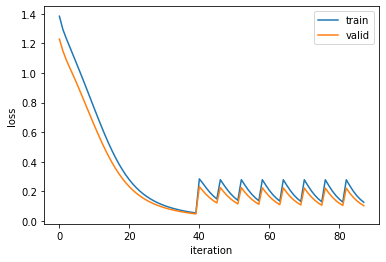

In [1783]:
trainer.plot('loss','all')

In [1782]:
trainer.fit(epochs=6)

[1/6] - train :: accuracy: 1.0000 | loss: 0.2785 
        valid :: accuracy: 1.0000 | loss: 0.2219 
        epoch time: 00 s 568 ms


[2/6] - train :: accuracy: 1.0000 | loss: 0.2385 
        valid :: accuracy: 1.0000 | loss: 0.1882 
        epoch time: 00 s 552 ms


[3/6] - train :: accuracy: 1.0000 | loss: 0.2017 
        valid :: accuracy: 1.0000 | loss: 0.1599 
        epoch time: 00 s 445 ms


[4/6] - train :: accuracy: 1.0000 | loss: 0.1710 
        valid :: accuracy: 1.0000 | loss: 0.1369 
        epoch time: 00 s 576 ms


[5/6] - train :: accuracy: 1.0000 | loss: 0.1462 
        valid :: accuracy: 1.0000 | loss: 0.1183 
        epoch time: 00 s 416 ms


[6/6] - train :: accuracy: 1.0000 | loss: 0.1263 
        valid :: accuracy: 1.0000 | loss: 0.1033 
        epoch time: 00 s 370 ms

-----
total time: 02 s 993 ms
best score: 1.0000


In [1754]:
trainer.M.phases

['test']

#### Execution

In [1423]:
# trainer.fit(epochs=3, train_dl=dl[TR], valid_dl=dl[VA])
trainer.fit(epochs=2)

[1/2] - train :: loss: 1.3984 | accu: 0.2428 
        valid :: loss: 1.3488 | accu: 0.3719 
        epoch time: 02 s 996 ms


[2/2] - train :: loss: 1.3490 | accu: 0.3881 
        valid :: loss: 1.2926 | accu: 0.6198 
        epoch time: 02 s 891 ms

-----
total time: 05 s 922 ms
best score: 0.6198


In [1742]:
trainer.test()

test :: accuracy: 0.3478 | loss: 1.3875 

-----
total time: 00 s 182 ms


In [1525]:
# trainer.run_sanity_check(use_test_dl=True,steps=None, train_dl=dl[TR], valid_dl=dl[VA], test_dl=dl[TE])
trainer.run_sanity_check(use_test_dl=True,steps=None)

RUNNING SANITY CHECK: TRAIN LOOP - 1 EPOCH(s), None STEP(s)


[1/1] - train :: accuracy: 0.9615 | loss: 0.8845 
        valid :: accuracy: 1.0000 | loss: 0.7679 
        epoch time: 00 s 435 ms

-----
total time: 00 s 467 ms
best score: 1.0000

RUNNING SANITY CHECK: TEST LOOP - None STEP(s)


test :: accuracy: 0.9565 | loss: 0.8922 

-----
total time: 00 s 175 ms


In [1527]:
# _ = trainer.run_profiler(epochs=2, steps=None, train_dl=dl[TR], valid_dl=dl[VA], test_dl=dl[TE])
_ = trainer.run_profiler()

RUNNING PROFILER: TRAIN LOOP 1 EPOCH(s)
  train dl :: batches:   11 batch_size:    5 last_batch:    2 dataset_size:     52
  valid dl :: batches:    3 batch_size:    5 last_batch:    2 dataset_size:     12




RUNNING PROFILER: TEST LOOP 
  test  dl :: batches:    5 batch_size:    5 last_batch:    3 dataset_size:     23




AVERAGE TIMES
1. initialize:       00 s 002 ms 376 us
2. train
  1. epoch_start:    00 s 195 ms 899 us
  2. step:           00 s 002 ms 212 us
  3. batch_inner:    00 s 002 ms 683 us
  4. batch_loop:     00 s 309 ms 984 us
  5. epoch_end:      00 s 226 ms 800 us
  6. phase_inner:    00 s 310 ms 140 us
3. valid
  1. epoch_start:    00 s 785 ms 004 us
  2. step:           00 s 000 ms 549 us
  3. batch_inner:    00 s 001 ms 121 us
  4. batch_loop:     00 s 059 ms 311 us
  5. epoch_end:      00 s 020 ms 299 us
  6. phase_inner:    00 s 059 ms 455 us
4. phase loop:       00 s 398 ms 314 us
5. epoch
  1. inner:          00 s 400 ms 646 us
  2. loop:           00 s 429 ms 772 us
  3. inner_t:        00 s 170 ms 788 us
  4. loop_t:         00 s 170 ms 992 us
6. restore model:    00 s 001 ms 514 us
7. total:            00 s 433 ms 714 us
8. initialize_t:     00 s 000 ms 940 us
9. test
  1. epoch_start_t:  00 s 181 ms 996 us
  2. step_t:         00 s 001 ms 010 us
  3. batch_inner_t:  00 s 001 

## TODO

### FitLoop

- Bare minimum to structure and push to Pypi:
    - Test on console.
    - Metrics plot
    - Onchanging model update parameters appropriately
    - ✅Metrics Viz
    - ✅FitLoopDefaults (really simple ones)
    - ✅All stage functions except for `train_step` should be optional that's the only one that is required for training the model, rest all are for metric keeping.
    - ✅Make it easy to train, validate, test with some other DataLoader that is not attached to the object.
    - ✅Fix No Continue
    - ✅Metrics
- `FitLoop.save(path:str)` to save the model and training state somehow even the FitLoop state.
- `FitLoop.load(path:str)` to load the FitLoop state from given path.
- ✅`FitLoop.profiler()` mode to capture all stage timings and maybe even CPU, GPU, RAM usage to check for bottlenecks and usage spikes, to be used with timed_test.
- ✅if `FitLoop.fit(define_all:bool=False)` the zero_grad and the context manager are not auto set.
- ✅should keep track of epochs that have been completed
- ✅epoch_number can be reset 
- ✅`FitLoop.metrics.set_name.loop_stage['metric_name']` to access the metric
- ✅`FitLoop.store_pretrained:bool` arg to store the pretrained weights before training
    if path then store at given path else store in memory.
- ✅`FitLoop.reset(reset_model:bool)` to clear metrics, epoch_num and to reset the model, to pretrained state
    will load the weight from passed path else from memory.
- ✅`FitLoop.fit(continue_loop:int=0)` ask after `int` whether to continue training or to end.
- ✅`FitLoop.fit(profiler:bool=False)` mode to capture all stage timings and maybe even CPU, GPU, RAM usage to check for bottlenecks and usage spikes, to be used with timed_test.
- ✅Functionality to view the metrics.
- ✅Model score should be a loop instance so that the best model may not be erased.
- ✅Time keeping/ metric keeping:
    - General
        - ✅Metrics returned in the batch step
        - ✅Metrics returned in the end step
        - ✅Progress bar for epoch
        - ✅Progress bar for batch that disappears after complete
        - ✅Epoch timing (for both phases when training)
        - ✅Total timing 
        
    - Profiler Mode:
        - ✅Individual Stage Timings
        
- ✅Check with uneven batchsizes.
 
#### Later Incremental Addons
- Profiler Mode:
    - Use an actual profiler ie: `cProfile`
    - Individual Stage CPU Usage
    - Individual Stage GPU Usage
    - Individual Stage RAM Usage
- Use better logging (maybe) `warnings` and `logging`

### ✅FitLoopDefaults

- ✅Basic functions for
    - ✅train_step
    - ✅valid_step
    - ✅test_step
- ✅Basic funtions for 
    - ✅train_epoch_end
    - ✅valid_epoch_end
    - ✅test_epoch_end

*FitLoopDefaults shouldn't be a class, it should be a module.*

### ✅Metrics/MetricsAggregator

```python
# Value access
Fitloop.metrics.train['loss']                 # ✅returns all losses from epoch end
Fitloop.metrics.train.epoch_end['loss']       # ✅returns all losses from epoch end
Fitloop.metrics.train.epoch_start['loss']     # ✅returns all losses from epoch start
Fitloop.metrics.train.batch_step['loss']      # ✅returns all losses from batch step
 
Fitloop.metrics.train['loss'][0]              # ✅returns losses for run 0 from epoch end
Fitloop.metrics.valid.batch_step['accu'][3]   # ✅returns all validation accuracies for batch step from run 3
 
# Value visualization 
Fitloop.metrics.plot()                        # ✅plots validation criteria against training criteria (eg accuracy)
                                              # ✅if criteria not available, then first key from rdict.
Fitloop.metrics.train.plot()                  # ✅if loss then loss else, plots first value from rdict
Fitloop.metrics.train.plot('loss')            # ✅plots loss 
```
- ✅metrics can be cleared

### ✅LoopState 

- ✅should cast the batch to device before passing it using `state.batch()`
- ✅should get the batch num `state.batch_num` and epoch num `state.epoch_num`
- ✅the model, optimizer, loss_function, lr_scheduler should be available
    `state.model`, `state.optimizer`, `state.loss_function`, `state.lr_scheduler`
- ✅should return the batch metrics as float tensors using square bracket indexing
    `state['loss']` 
    - every step function hook receives the LoopState object.
- ✅The loop state object should have a copy of all the values returned from the function hook
- ✅example the below returned dict values should be avialable in the LoopState object

```python
def train_step(state):
    X,y = state() # should device cast automatically
    y_ = state.model(X)
    loss = state.loss_function(y_, y)
    
    state.optimizer.zero_grad()
    loss.backward()
    state.optimizer.step()
    state.lr_scheduler.step() 
    
    loss = loss.item()
    batch_loss = loss * y.size()
    batch_corr = (y_.argmax(dim=0) == y).sum().float().item()
    
    return {'loss':loss,'batch_loss':batch_loss:'batch_corr'}
```
- ✅The LoopState object should be cleared of the above values at the start 
  of the next epoch.
- ✅The returned values should be available through the FitLoop object
  Eg: `FitLoop.metrics.train.batch['loss']`
- ✅The (above statement) returned value should be optionally available by setting the flag 
  `track_batch_metrics`

```python
def train_epoch_end(state):
    loss = state['loss']
    batch_loss = state['batch_loss']
    batch_corr = state['batch_corr']
    
    size = state.size
    
    epoch_loss = batch_loss.sum().item()/size
    epoch_accu = batch_corr.sum().item()/size
    
    return {"loss":epoch_loss,"accu":epoch_accu}
```

- ✅The returned values should be available through the FitLoop object
  Eg: `FitLoop.metrics.train.epoch['loss']`
- ✅For each phase a different LoopState obect is maintained.

